In [1]:
import numpy as np 
import pandas as pd 
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')


In [2]:
dataset=pd.read_csv('data.csv')

In [3]:
dataset.head()

,tweet,language,sentiment
0,"Lionel Messi, que ha estado vinculado con un t...",es,3 stars
1,This is a guest post by The Joy of Truth. To r...,en,4 stars
2,Nous sommes tous conscients de la popularité d...,fr,5 stars
3,El baño en el sistema de metro de la ciudad de...,es,4 stars
4,"""Ich habe dies seit über 20 Jahren getan und i...",de,5 stars


In [4]:
dataset.describe()

,tweet,language,sentiment
count,4917,4917,4917
unique,4861,5,5
top,. . . . . . . . . . . . . . . . . . . . . . . .,fr,1 star
freq,17,991,1461


In [5]:
dataset['language'].unique()

array(['es', 'en', 'fr', 'de', 'it'], dtype=object)

In [6]:
dataset['sentiment'].unique()

array(['3 stars', '4 stars', '5 stars', '2 stars', '1 star'], dtype=object)

In [8]:
# Define the mapping function
def map_sentiment(stars):
    if stars in ['4 stars', '5 stars']:
        return 'positive'
    elif stars == '3 stars':
        return 'neutral'
    else:
        return 'negative'

# Apply the mapping function to the sentiment column
dataset['sentiment'] = dataset['sentiment'].apply(map_sentiment)

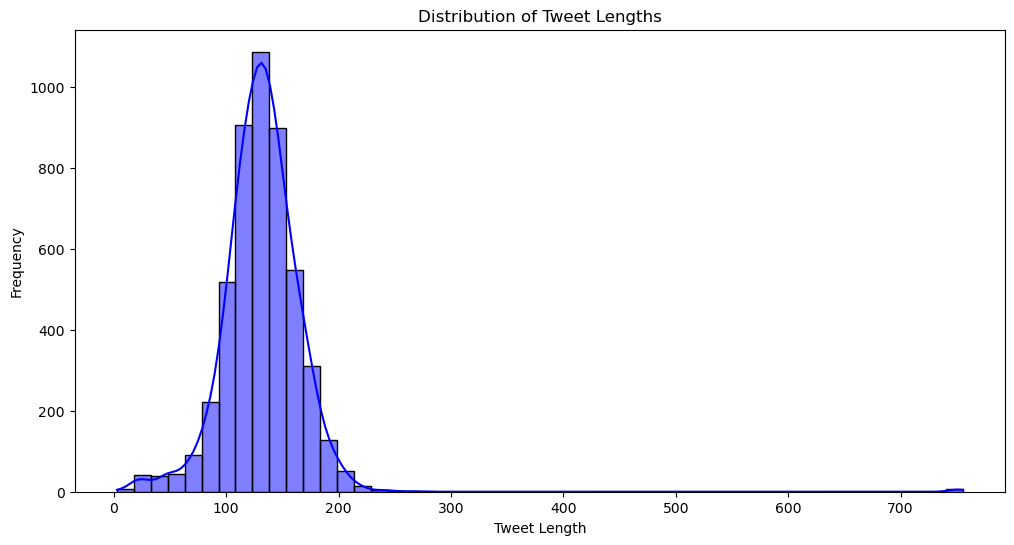

In [9]:
# Add a new column for tweet length
dataset['tweet_length'] = dataset['tweet'].apply(len)

# Plot the distribution of tweet lengths
plt.figure(figsize=(12, 6))
sns.histplot(dataset['tweet_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

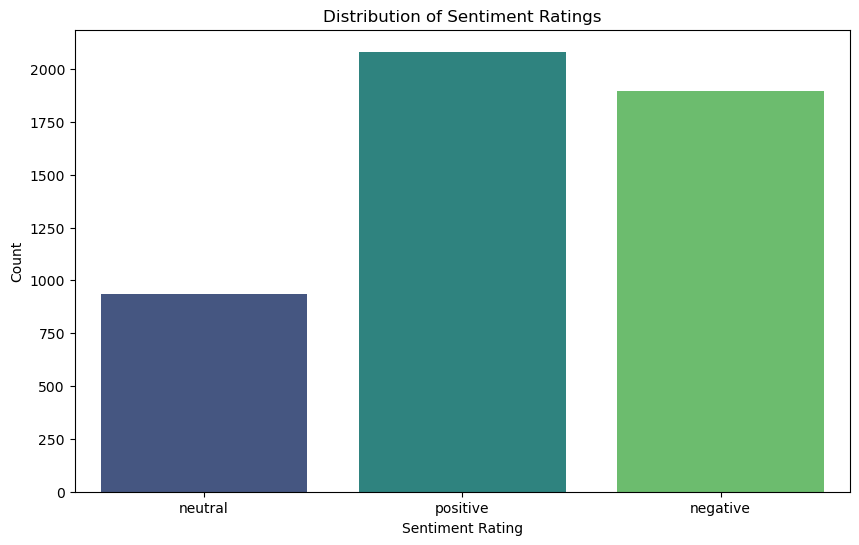

In [10]:

# Plot the distribution of sentiment ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=dataset, palette='viridis')
plt.title('Distribution of Sentiment Ratings')
plt.xlabel('Sentiment Rating')
plt.ylabel('Count')
plt.show()



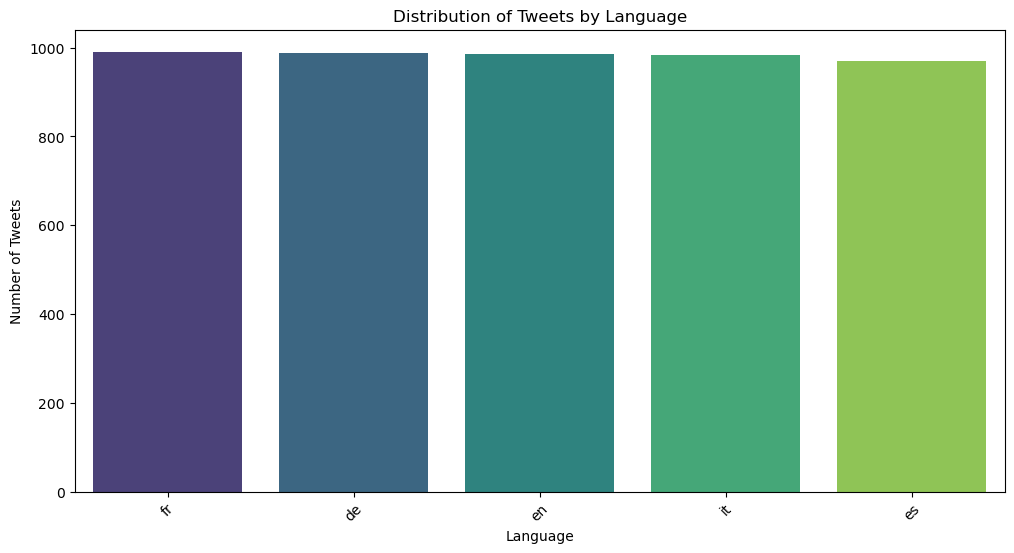

In [11]:

# Count the number of tweets per language
language_counts = dataset['language'].value_counts()

# Plot the distribution of languages
plt.figure(figsize=(12, 6))
sns.barplot(x=language_counts.index, y=language_counts.values, palette='viridis')
plt.title('Distribution of Tweets by Language')
plt.xlabel('Language')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.show()

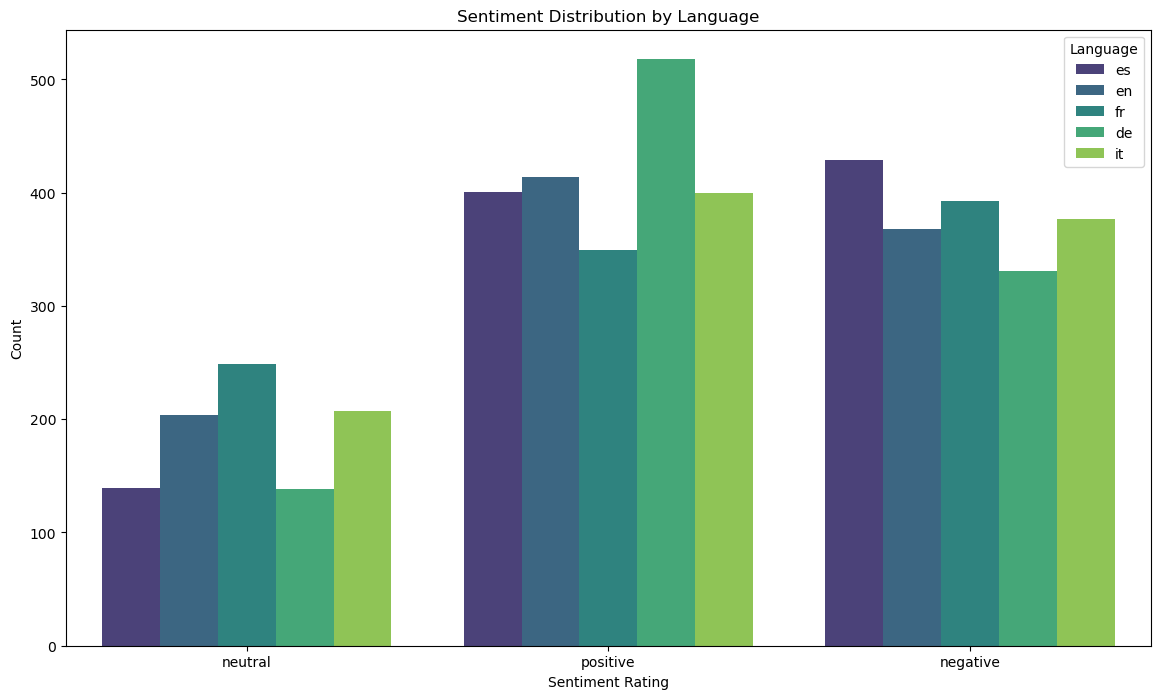

In [12]:
# Plot the sentiment distribution for each language
plt.figure(figsize=(14, 8))
sns.countplot(x='sentiment', hue='language', data=dataset, palette='viridis')
plt.title('Sentiment Distribution by Language')
plt.xlabel('Sentiment Rating')
plt.ylabel('Count')
plt.legend(title='Language')
plt.show()


In [13]:
from googletrans import Translator

In [14]:

from googletrans import Translator


# Initialize the translator
translator = Translator()

# Function to translate text from any language to English
def translate_to_english(text):
    try:
        # Detect the language
        detected_lang = translator.detect(text).lang
        # Translate only if the detected language is not English
        if detected_lang != 'en':
            translated = translator.translate(text, src=detected_lang, dest='en')
            return translated.text
        return text
    except Exception as e:
        return text 

# Apply the translation function to the text column
dataset['tweet_english'] = dataset['tweet'].apply(translate_to_english)


In [15]:
dataset.head()

,tweet,language,sentiment,tweet_length,tweet_english
0,"Lionel Messi, que ha estado vinculado con un t...",es,neutral,139,"Lionel Messi, who has been linked to a transfe..."
1,This is a guest post by The Joy of Truth. To r...,en,positive,114,This is a guest post by The Joy of Truth. To r...
2,Nous sommes tous conscients de la popularité d...,fr,positive,117,We are all aware of the popularity of the Inte...
3,El baño en el sistema de metro de la ciudad de...,es,positive,102,The bathroom in the subway system of New York ...
4,"""Ich habe dies seit über 20 Jahren getan und i...",de,positive,131,"""I've been doing this for over 20 years and I ..."


# data cleaning

In [16]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [17]:
dataset['tweet_english'] = dataset['tweet_english'].apply(lambda x:clean_text(x))
dataset.head()

,tweet,language,sentiment,tweet_length,tweet_english
0,"Lionel Messi, que ha estado vinculado con un t...",es,neutral,139,lionel messi who has been linked to a transfer...
1,This is a guest post by The Joy of Truth. To r...,en,positive,114,this is a guest post by the joy of truth to re...
2,Nous sommes tous conscients de la popularité d...,fr,positive,117,we are all aware of the popularity of the inte...
3,El baño en el sistema de metro de la ciudad de...,es,positive,102,the bathroom in the subway system of new york ...
4,"""Ich habe dies seit über 20 Jahren getan und i...",de,positive,131,ive been doing this for over years and i know...


In [18]:
dataset['language'] = dataset['language'].apply(lambda x:clean_text(x))
dataset.head()

,tweet,language,sentiment,tweet_length,tweet_english
0,"Lionel Messi, que ha estado vinculado con un t...",es,neutral,139,lionel messi who has been linked to a transfer...
1,This is a guest post by The Joy of Truth. To r...,en,positive,114,this is a guest post by the joy of truth to re...
2,Nous sommes tous conscients de la popularité d...,fr,positive,117,we are all aware of the popularity of the inte...
3,El baño en el sistema de metro de la ciudad de...,es,positive,102,the bathroom in the subway system of new york ...
4,"""Ich habe dies seit über 20 Jahren getan und i...",de,positive,131,ive been doing this for over years and i know...


In [19]:
def remove_stopword(text):
    if pd.notnull(text):
        stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(text)
        filtered_text = [word for word in tokens if word not in stop_words]
        return ' '.join(filtered_text)
    return text


In [20]:
def lemmatize_text(text):
    if pd.notnull(text):
        lemmatizer = WordNetLemmatizer()
        tokens = word_tokenize(text)
        lemmatized_text = [lemmatizer.lemmatize(word) for word in tokens]
        return ' '.join(lemmatized_text)
    return text

In [21]:
# Rest of your code
dataset['tweet_english'] = dataset['tweet_english'].apply(lambda x: remove_stopword(x))
dataset['tweet_english'] = dataset['tweet_english'].apply(lambda x: lemmatize_text(x))


In [22]:
dataset['tweet']

0       Lionel Messi, que ha estado vinculado con un t...
1       This is a guest post by The Joy of Truth. To r...
2       Nous sommes tous conscients de la popularité d...
3       El baño en el sistema de metro de la ciudad de...
4       "Ich habe dies seit über 20 Jahren getan und i...
                              ...                        
4912    \nA former CIA officer and CIA director has pl...
4913    Karen M. Felt, Ph.D. La ricerca è stata condot...
4914    Mit all der Aufmerksamkeit, die dem Thema Abtr...
4915    L'élément le plus important dans le processus ...
4916    On voit souvent dans les films quelqu'un qui a...
Name: tweet, Length: 4917, dtype: object

In [23]:
dataset.head()

,tweet,language,sentiment,tweet_length,tweet_english
0,"Lionel Messi, que ha estado vinculado con un t...",es,neutral,139,lionel messi linked transfer barcelona ​​is li...
1,This is a guest post by The Joy of Truth. To r...,en,positive,114,guest post joy truth read essay topic check ne...
2,Nous sommes tous conscients de la popularité d...,fr,positive,117,aware popularity internetthis due fact huge ma...
3,El baño en el sistema de metro de la ciudad de...,es,positive,102,bathroom subway system new york city also key ...
4,"""Ich habe dies seit über 20 Jahren getan und i...",de,positive,131,ive year know hard fight done past year
